In [1]:
import sys, os
sys.path.insert(0, '../')
sys.path.insert(0, '../python_src/')

import numpy as np
import scipy as sp
import numpy.random as rand
import numpy.linalg as la
import gzip
import cPickle as pickle
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns
import networkx as nx
import itertools as it
%matplotlib inline

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib import collections as mc

import mech_network_solver as mns
import network
import tuning_algs as talgs
import network_plot as nplot

Loading Mechanical Network Deformation Solver Module


In [87]:
DIM = 2

NN = 512
Lp = -1.0
irec = 100
Delta = 0.1
NTS = 1


NDISC = 1.0

rand.seed(irec)

nw_label = "network_periodic_jammed/network_N{:05d}_Lp{:.2f}/network_irec{:04d}".format(NN, Lp, irec)

with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net = nw_data['network'] 


NF = 1


edgei = net.edgei
edgej = net.edgej


inodesi = [[] for t in range(NF)]
inodesj = [[] for t in range(NF)]
istrain_bonds = [[] for t in range(NF)]

onodesi = [[] for t in range(NF)]
onodesj = [[] for t in range(NF)]
ostrain_bonds = [[] for t in range(NF)]



##################################################

L = np.copy(net.L)

pos = np.array([0.35*L[0], 0.35*L[1]])
s = network.closestEdge(net, pos)[0]


inodesi[0].append(edgei[s])
inodesj[0].append(edgej[s])
istrain_bonds[0].append(s)

dtheta = 2*np.pi / 4


pos = np.array([0.65*L[0], 0.65*L[1]])
b = network.closestEdge(net, pos)[0]

onodesi[0].append(edgei[b])
onodesj[0].append(edgej[b])
ostrain_bonds[0].append(b)
    
# edge = range(net.NE)

# rand.shuffle(edge)

# for i in range(NTS):
#     b = edge.pop()

#     onodesi[0].append(edgei[b])
#     onodesj[0].append(edgej[b])
#     ostrain_bonds[0].append(b)

######################################################


isvec = [[] for t in range(NF)]
for t in range(NF):
    for (i, j) in zip(inodesi[t], inodesj[t]):
        posi = net.node_pos[DIM*i:DIM*i+DIM]
        posj = net.node_pos[DIM*j:DIM*j+DIM]
        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        isvec[t].extend(bvec) 

istrain = [[] for t in range(NF)]
istrain[0].append(1.0)


osvec = [[] for t in range(NF)]
ostrain = [[] for t in range(NF)]
for t in range(NF):
    for (i, j) in zip(onodesi[t], onodesj[t]):
        posi = net.node_pos[DIM*i:DIM*i+DIM]
        posj = net.node_pos[DIM*j:DIM*j+DIM]
        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        osvec[t].extend(bvec) 


        ostrain[t].append(Delta)

pert = []
meas = []
for t in range(NF):
    pert.append(talgs.Perturb())
    pert[t].setInputStress(len(istrain_bonds[t]), istrain_bonds[t], istrain[t])
#     pert[t].setInputStrain(len(inodesi[t]), inodesi[t], inodesj[t], istrain_bonds[t], istrain[t], isvec[t])

    meas.append(talgs.Measure())
    meas[t].setOutputStress(len(ostrain_bonds[t]), ostrain_bonds[t])
#     meas[t].setOutputStrain(len(onodesi[t]), onodesi[t], onodesj[t], ostrain_bonds[t], osvec[t])

obj_func = mns.CyIneqRatioChangeObjFunc(len(np.concatenate(ostrain)), net.NE, 
                                        np.zeros(len(np.concatenate(ostrain)), float), np.concatenate(ostrain),
                                       relative=False, change=False)    


K_max = np.ones(net.NE, float) / net.eq_length

K_disc = np.ones(net.NE, float)


tuner = talgs.TuneDiscLin(net, pert, meas, obj_func, K_max, K_disc, NDISC=NDISC)

data = tuner.tune()

print data

data['network_label'] = nw_label
data['istrain_nodesi'] = inodesi
data['istrain_nodesj'] = inodesj
data['istrain'] = istrain
data['istrain_edges'] = istrain_bonds

data['ostrain_nodesi'] = onodesi
data['ostrain_nodesj'] = onodesj
data['delta_ostrain_target'] = ostrain
data['ostrain_edges'] = ostrain_bonds
tuner.solver.setIntStrengths(data['K'])
(disp, strain) = tuner.solver.solveDOF()
data['disp'] = disp[0]

Initial objective function: 0.00498232003097
Removing 0 / 1417.0 / 1417 bonds would create zero modes...
{'disc': 0.0, 'bond': 1064}
0 Objective function: 0.00487200465523 Change: -0.000110315375734 Percent: -2.2141366883 %
Removing 0 / 1416.0 / 1417 bonds would create zero modes...
{'disc': 0.0, 'bond': 372}
1 Objective function: 0.00450754022504 Change: -0.000364464430193 Percent: -7.4807898593 %
Removing 0 / 1415.0 / 1417 bonds would create zero modes...
{'disc': 0.0, 'bond': 386}
2 Objective function: 0.00401002434707 Change: -0.000497515877973 Percent: -11.037414047 %
Removing 0 / 1414.0 / 1417 bonds would create zero modes...
{'disc': 0.0, 'bond': 365}
3 Objective function: 0.00365312434056 Change: -0.000356900006504 Percent: -8.90019550044 %
Removing 0 / 1413.0 / 1417 bonds would create zero modes...
{'disc': 0.0, 'bond': 793}
4 Objective function: 0.00328419665036 Change: -0.000368927690197 Percent: -10.0989634024 %
Removing 0 / 1412.0 / 1417 bonds would create zero modes...
{'

In [88]:
#Set initial response ratio

obj_func = mns.CyIneqRatioChangeObjFunc(len(np.concatenate(ostrain)), net.NE, 
                                        np.zeros(len(np.concatenate(ostrain)), float), np.concatenate(ostrain),
                                       relative=False)    



tuner = talgs.TuneDiscLin(net, pert, meas, obj_func, K_max, K_disc, NDISC=NDISC)
  
tuner.solver.setIntStrengths(K_max * K_disc)
meas_init = tuner.solver.solveMeas()

print meas_init

obj_func.setRatioInit(meas_init)

move_list = []
for b in range(net.NE):
    if data['K_disc'][b] == 0.0:
        move_list.append({'bond': b, 'disc': 1.0})
    else:
        move_list.append({'bond': b, 'disc': 0.0})
        
up_list = []
for move in move_list:
    up = talgs.Update()
    up.setStretchMod(1, [move['bond']], [K_max[move['bond']] * move['disc'] / NDISC])
    up_list.append(up.getCyUpdate())

    
tuner.solver.setIntStrengths(K_max * data['K_disc'])

meas_final = tuner.solver.solveMeas()
print meas_final

tuner.solver.prepareUpdateList(up_list)

zm_edges = []
cviol_edges = []
cviol_obj = np.zeros(net.NE, float)


for i, move in enumerate(move_list):     
                    
        bond = move['bond']
        disc = move['disc']

        bi = net.edgei[bond]
        bj = net.edgej[bond]

        (condition, m) = tuner.solver.solveMeasUpdate(i)
        
        if condition < 0.0:
            zm_edges.append(bond)                 
        else:
            obj = tuner.obj_func.objFunc(np.concatenate(m))
            if obj > 0.0:
                cviol_edges.append(bond)
                cviol_obj[bond] = obj

                
print zm_edges
print cviol_edges

[ 0.00017696]
[ 0.11535717]
[]
[365, 369, 370, 371, 372, 384, 385, 386, 391, 428, 430, 435, 441, 698, 706, 727, 736, 738, 779, 780, 792, 793, 795, 1019, 1050, 1054, 1060]


In [89]:
nodes_to_edge = {}
for i in range(net.NE):
    nodes_to_edge[tuple(sorted((net.edgei[i], net.edgej[i])))] = i


G = nx.Graph()
G.add_nodes_from(range(net.NN))
G.add_edges_from(zip(net.edgei, net.edgej))

# nx.draw(G, node_size=4)
# plt.show()

def angle(ni, nj):
    posi = net.node_pos[DIM*ni:DIM*ni+DIM]
    posj = net.node_pos[DIM*nj:DIM*nj+DIM]
    bvec = posj - posi
    bvec -= np.rint(bvec / net.L) * net.L
    bvec /= la.norm(bvec)
        
    theta = np.arctan2(bvec[1], bvec[0])
    
    return theta

DG = G.to_directed()
unvisited = set(DG.edges())

facets_to_nodes = []

cedge = unvisited.pop()
facet = [cedge[0], cedge[1]]

# for i in range(10):
while len(unvisited) > 0:

    ci = cedge[0]
    cj = cedge[1]
    ctheta = angle(ci, cj) + np.pi 
        
#     print "Current Facet:", facet
#     print "Current Edge:", cedge
    
        
    neighbors = []
    nangles = []
    for neigh in DG.neighbors(cj):
        if (cj, neigh) not in unvisited:
            continue
        
        ntheta = angle(cj, neigh) 
        
        dtheta = ctheta - ntheta
        dtheta -= np.floor(dtheta / (2*np.pi)) * 2*np.pi
        
        if neigh == ci:
            dtheta += 2*np.pi
                
        neighbors.append(neigh)
        nangles.append(dtheta)
        
    cedge = (cj, neighbors[np.argmin(nangles)])
    
#     print "Next Edge", cedge
    
    unvisited.discard(cedge)
        
    if facet[0] == cedge[1]:
        
#         print "Found new facet:", facet
        
        facets_to_nodes.append(np.copy(facet))
         
        if len(unvisited) > 0:
            cedge = unvisited.pop()
            facet = [cedge[0], cedge[1]]
    else:
        facet.append(cedge[1])                

print "Number Facets:", len(facet_list)

edges_to_facets = {tuple(sorted(edge)): [] for edge in G.edges()}

for fi, facet in enumerate(facets_to_nodes):
    for i in range(len(facet)):
        ni = facet[i]
        nj = facet[(i+1) % len(facet)]
        
        edges_to_facets[tuple(sorted((ni, nj)))].append(fi)
        
dual_NN = len(facets_to_nodes) 
dual_G = nx.Graph()
dual_G.add_nodes_from(range(dual_NN))
for key in edges_to_facets:
    dual_G.add_edge(*edges_to_facets[key])

Number Facets: 892


0.0 0.0378691262594


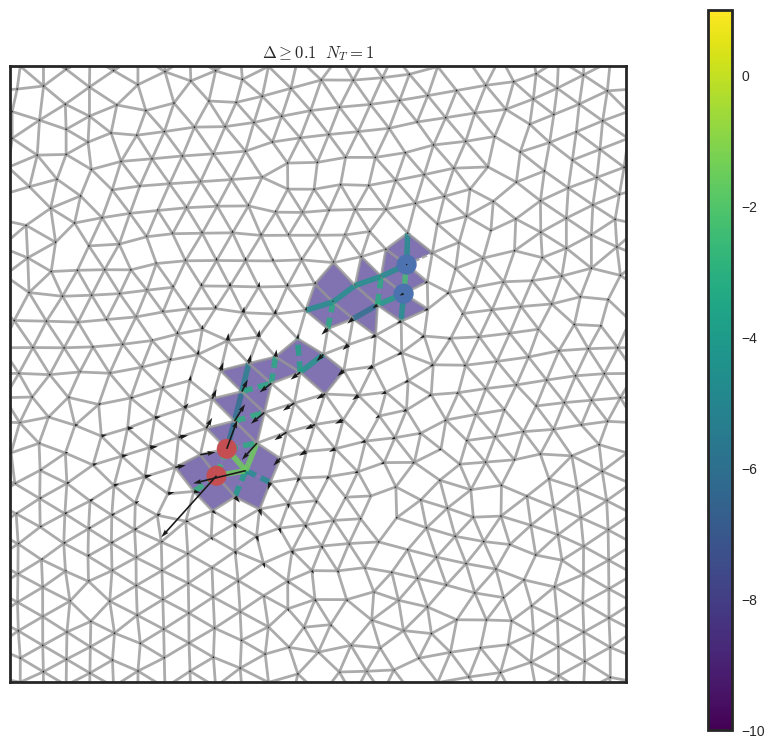

In [90]:
mpl.rcParams['mathtext.fontset'] = 'cm'
sns.set_context('poster', font_scale=1.25)
# sns.set_color_codes(palette='deep')
sns.set(color_codes=True, palette='deep')
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1, 1, 1, aspect=1.0)

nw_label = data['network_label']
inodesi = data['istrain_nodesi'][0]
inodesj = data['istrain_nodesj'][0]
onodesi = data['ostrain_nodesi'][0]
onodesj = data['ostrain_nodesj'][0]
ostrain_edgesneights = data['ostrain_edges'][0]

removed = np.where(data['K_disc'] == 0.0)[0]
disp = data['disp']

with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net = nw_data['network'] 

styles = {}    
# for edge in set(DG.edges())-unvisited:
#     i = nodes_to_edge[tuple(sorted(edge))]
#     styles[i] = {}
#     styles[i]['color'] = 'r'

center = 0.5 * np.ones(DIM, float)


palette = it.cycle(sns.color_palette("deep"))

patches = []
colors = ['white' for i in range(dual_NN)]
for fi, facet in enumerate(facets_to_nodes):
    corners = np.zeros([len(facet), 2], float)
    
    posi = net.node_pos[DIM*facet[0]:DIM*facet[0]+DIM] / net.L
    corners[0] = posi - np.floor(posi) - center
    
    
    for j in range(1,len(facet)):
        posj = net.node_pos[DIM*facet[j]:DIM*facet[j]+DIM] / net.L
        
        bvec = posj - posi
        bvec -= np.rint(bvec)
        
        corners[j] = posi - np.floor(posi) - center + bvec
        
        posj = posi
        
    patches.append(mpatches.Polygon(corners))
#     colors[fi] = next(palette)
    
for edge in cviol_edges:
    for fi in edges_to_facets[tuple(sorted((net.edgei[edge], net.edgej[edge])))]:
        colors[fi] = 'm'
    
pc = mc.PatchCollection(patches, color=colors, zorder=-1)
# pc.set_array(100*np.random.rand(len(patches)))
ax1.add_collection(pc)
     

styles = {edge: {} for edge in range(net.NE)}
for edge in removed:
    styles[edge]['ls'] = (0.0, (2.0,1.0))

for edge in zm_edges:
    styles[edge]['color'] = 'k'
    styles[edge]['lw'] = 4.0

print np.min(cviol_obj), np.max(cviol_obj)
    
norm = mcolors.Normalize(vmin=-10, vmax=1.0)
cmap = mpl.cm.viridis
smap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    
for edge in cviol_edges:
    styles[edge]['lw'] = 4.0
    styles[edge]['color'] = smap.to_rgba(np.log10(cviol_obj[edge]))
#     styles[edge]['color'] = 'r'
    
nplot.show_network(ax1, net, styles=styles)
    
    

styles = {}
for i in inodesi:
    styles[i] = {}
    styles[i]['color'] = 'r'
for i in inodesj:
    styles[i] = {}
    styles[i]['color'] = 'r'
    
for i in onodesi:
    styles[i] = {}
    styles[i]['color'] = 'b'
for i in onodesj:
    styles[i] = {}
    styles[i]['color'] = 'b'

nplot.show_nodes(ax1, net, styles.keys(), styles=styles)
nplot.show_vecs(ax1, net, disp / np.max(np.abs(disp)))


# ax1.set_title(r'$e_T \geq {}$'.format(Delta))
ax1.set_title(r'$\Delta \geq {0}$  $N_T = {1}$'.format(Delta, NTS))

cax = fig.add_axes([1.0, 0.05, 0.03, 0.90])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
# cbar.set_label(r'$\Delta \eta / \eta_0$')
# cbar.ax.tick_params(labelsize=20)


ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

plt.show()

0.0 2.28658840069


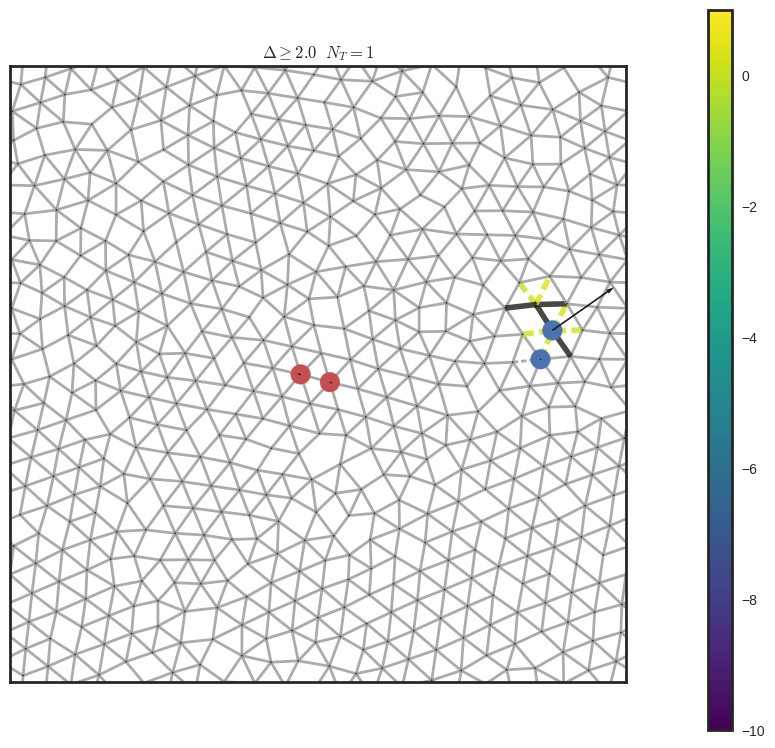

In [48]:
mpl.rcParams['mathtext.fontset'] = 'cm'
sns.set_context('poster', font_scale=1.25)
# sns.set_color_codes(palette='deep')
sns.set(color_codes=True, palette='deep')
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1, 1, 1, aspect=1.0)

nw_label = data['network_label']
inodesi = data['istrain_nodesi'][0]
inodesj = data['istrain_nodesj'][0]
onodesi = data['ostrain_nodesi'][0]
onodesj = data['ostrain_nodesj'][0]
ostrain_edges = data['ostrain_edges'][0]

removed = np.where(data['K_disc'] == 0.0)[0]
disp = data['disp']

with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net = nw_data['network'] 

    

styles = {edge: {} for edge in range(net.NE)}
for edge in removed:
    styles[edge]['ls'] = (0.0, (2.0,1.0))

for edge in zm_edges:
    styles[edge]['color'] = 'k'
    styles[edge]['lw'] = 4.0

print np.min(cviol_obj), np.max(cviol_obj)
    
norm = mcolors.Normalize(vmin=-10, vmax=1.0)
cmap = mpl.cm.viridis
smap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    
for edge in cviol_edges:
    styles[edge]['lw'] = 4.0
    styles[edge]['color'] = smap.to_rgba(np.log10(cviol_obj[edge]))
#     styles[edge]['color'] = 'r'
    
nplot.show_network(ax1, net, styles=styles)

styles = {}
for i in inodesi:
    styles[i] = {}
    styles[i]['color'] = 'r'
for i in inodesj:
    styles[i] = {}
    styles[i]['color'] = 'r'
    
for i in onodesi:
    styles[i] = {}
    styles[i]['color'] = 'b'
for i in onodesj:
    styles[i] = {}
    styles[i]['color'] = 'b'

nplot.show_nodes(ax1, net, styles.keys(), styles=styles)
nplot.show_vecs(ax1, net, disp / np.max(np.abs(disp)))

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

# ax1.set_title(r'$e_T \geq {}$'.format(Delta))
ax1.set_title(r'$\Delta \geq {0}$  $N_T = {1}$'.format(Delta, NTS))

cax = fig.add_axes([1.0, 0.05, 0.03, 0.90])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
# cbar.set_label(r'$\Delta \eta / \eta_0$')
# cbar.ax.tick_params(labelsize=20)

plt.show()

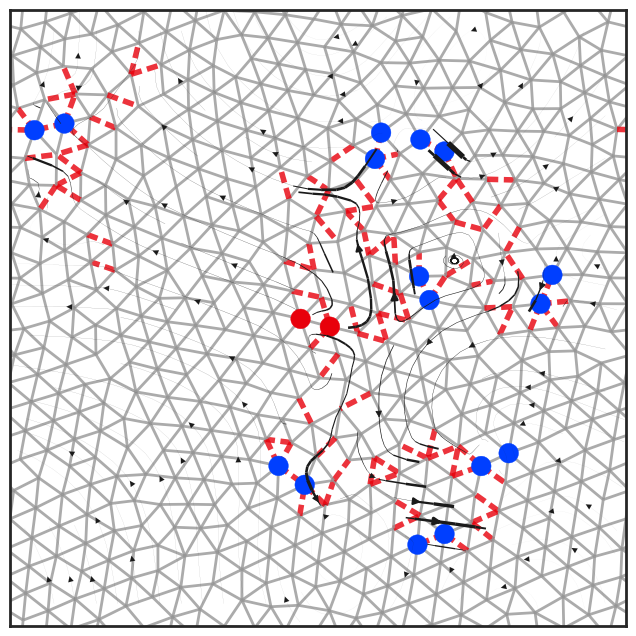

In [52]:
import network_plot as nplot


mpl.rcParams['mathtext.fontset'] = 'cm'
sns.set_context('poster', font_scale=1.25)
# sns.set_color_codes(palette='deep')
sns.set(color_codes=True, palette='bright')
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1, 1, 1, aspect=1.0)

nw_label = data['network_label']
inodesi = data['istrain_nodesi'][0]
inodesj = data['istrain_nodesj'][0]
onodesi = data['ostrain_nodesi'][0]
onodesj = data['ostrain_nodesj'][0]
ostrain_edges = data['ostrain_edges'][0]

removed = np.where(data['K_disc'] == 0.0)[0]
disp = data['disp']

with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net = nw_data['network'] 

    

styles = {edge: {} for edge in range(net.NE)}
for edge in removed:
    styles[edge]['ls'] = (0.0, (2.0,1.0))
    styles[edge]['lw'] = 4.0
    styles[edge]['color'] = 'r'
    
nplot.show_network(ax1, net, styles=styles)

styles = {}
for i in inodesi:
    styles[i] = {}
    styles[i]['color'] = 'r'
for i in inodesj:
    styles[i] = {}
    styles[i]['color'] = 'r'
    
for i in onodesi:
    styles[i] = {}
    styles[i]['color'] = 'b'
for i in onodesj:
    styles[i] = {}
    styles[i]['color'] = 'b'

nplot.show_nodes(ax1, net, styles.keys(), styles=styles)
nplot.show_vecs(ax1, net, disp, stream=True)


ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

plt.show()

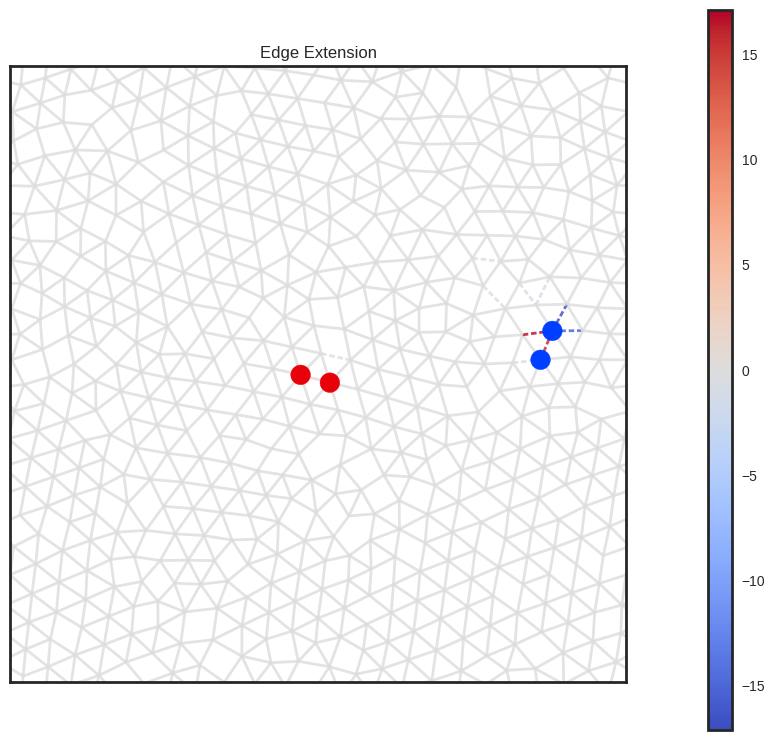

In [59]:
def calc_ext(net, disp):
    edgei = np.copy(net.edgei)
    edgej = np.copy(net.edgej)
    node_pos = np.copy(net.node_pos)
    DIM = net.DIM
    NE = net.NE
    NN = net.NN
    L = np.copy(net.L)
    
    ext = np.zeros(NE, float)
    for i in range(NE):
        
        posi = node_pos[DIM*edgei[i]:DIM*edgei[i]+DIM]
        posj = node_pos[DIM*edgej[i]:DIM*edgej[i]+DIM]

        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        
        bhat = bvec / la.norm(bvec)
        
        dispi = disp[DIM*edgei[i]:DIM*edgei[i]+DIM]
        dispj = disp[DIM*edgej[i]:DIM*edgej[i]+DIM]
        
        ext[i] = bhat.dot(dispj - dispi)
        
    return ext


mpl.rcParams['mathtext.fontset'] = 'cm'
sns.set_context('poster', font_scale=1.25)
# sns.set_color_codes(palette='deep')
sns.set(color_codes=True, palette='bright')
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1, 1, 1, aspect=1.0)

nw_label = data['network_label']
inodesi = data['istrain_nodesi'][0]
inodesj = data['istrain_nodesj'][0]
onodesi = data['ostrain_nodesi'][0]
onodesj = data['ostrain_nodesj'][0]
ostrain_edges = data['ostrain_edges'][0]

removed = np.where(data['K_disc'] == 0.0)[0]
disp = data['disp']

with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net = nw_data['network'] 


styles = {edge: {} for edge in range(net.NE)}
for edge in removed:
    styles[edge]['ls'] = (0.0, (2.0,1.0))

ext = calc_ext(net, disp)
        
limit = np.max([np.abs(np.min(ext)), np.abs(np.max(ext))])
norm = mcolors.Normalize(vmin=-limit, vmax=limit)
# norm = mcolors.Normalize(vmin=np.min(ext), vmax=np.max(ext))
cmap = mpl.cm.coolwarm
smap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

for edge in range(net.NE):
    styles[edge]['color'] = smap.to_rgba(ext[edge])    
    
    
nplot.show_network(ax1, net, styles=styles)

styles = {}
for i in inodesi:
    styles[i] = {}
    styles[i]['color'] = 'r'
for i in inodesj:
    styles[i] = {}
    styles[i]['color'] = 'r'
    
for i in onodesi:
    styles[i] = {}
    styles[i]['color'] = 'b'
for i in onodesj:
    styles[i] = {}
    styles[i]['color'] = 'b'

nplot.show_nodes(ax1, net, styles.keys(), styles=styles)
# nplot.show_vecs(ax1, net, disp)

ax1.set_title("Edge Extension")

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

cax = fig.add_axes([1.0, 0.05, 0.03, 0.90])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')

plt.show()

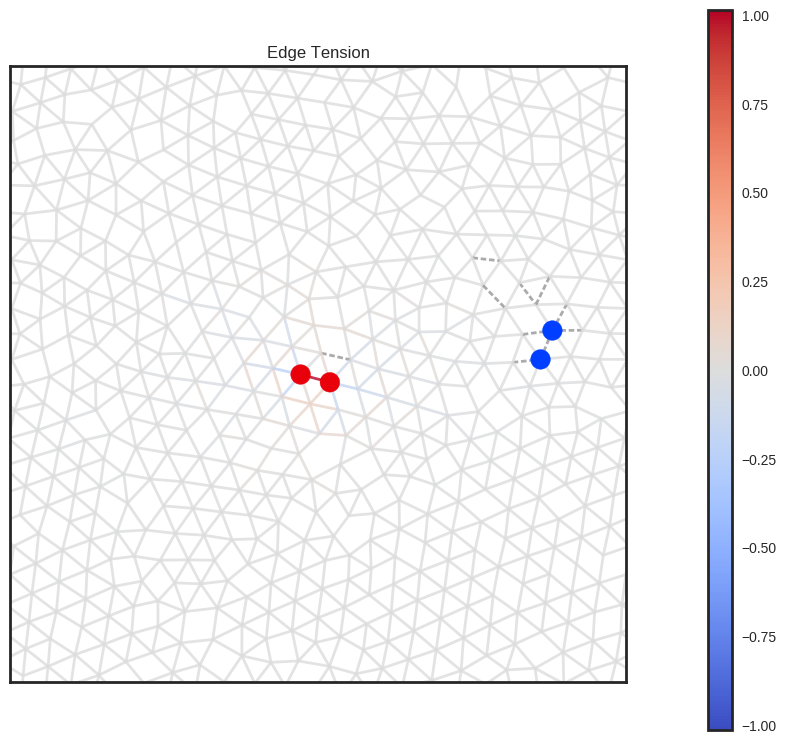

In [60]:
mpl.rcParams['mathtext.fontset'] = 'cm'
sns.set_context('poster', font_scale=1.25)
# sns.set_color_codes(palette='deep')
sns.set(color_codes=True, palette='bright')
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1, 1, 1, aspect=1.0)

nw_label = data['network_label']
inodesi = data['istrain_nodesi'][0]
inodesj = data['istrain_nodesj'][0]
onodesi = data['ostrain_nodesi'][0]
onodesj = data['ostrain_nodesj'][0]
ostrain_edges = data['ostrain_edges'][0]

removed = np.where(data['K_disc'] == 0.0)[0]
disp = data['disp']

with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net = nw_data['network'] 


styles = {edge: {} for edge in range(net.NE)}
for edge in removed:
    styles[edge]['ls'] = (0.0, (2.0,1.0))

tension = calc_ext(net, disp) * data['K']
# tension = np.where(tension == 0.0, 1.0, tension)
    
limit = np.max([np.abs(np.min(tension)), np.abs(np.max(tension))])
norm = mcolors.Normalize(vmin=-limit, vmax=limit)
# norm = mcolors.Normalize(vmin=np.min(tension), vmax=np.max(tension))
cmap = mpl.cm.coolwarm
smap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

for edge in range(net.NE):
    styles[edge]['color'] = smap.to_rgba(tension[edge])    
    
for edge in removed:
    del styles[edge]['color']
    
    
nplot.show_network(ax1, net, styles=styles)

styles = {}
for i in inodesi:
    styles[i] = {}
    styles[i]['color'] = 'r'
for i in inodesj:
    styles[i] = {}
    styles[i]['color'] = 'r'
    
for i in onodesi:
    styles[i] = {}
    styles[i]['color'] = 'b'
for i in onodesj:
    styles[i] = {}
    styles[i]['color'] = 'b'

nplot.show_nodes(ax1, net, styles.keys(), styles=styles)
# nplot.show_vecs(ax1, net, disp)

ax1.set_title("Edge Tension")

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

cax = fig.add_axes([1.0, 0.05, 0.03, 0.90])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')

plt.show()

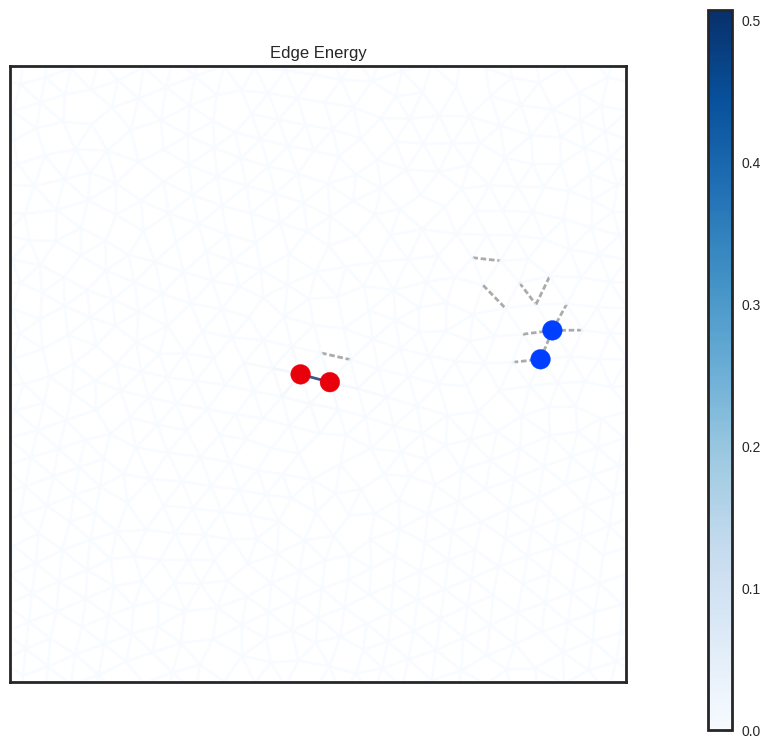

In [61]:
mpl.rcParams['mathtext.fontset'] = 'cm'
sns.set_context('poster', font_scale=1.25)
# sns.set_color_codes(palette='deep')
sns.set(color_codes=True, palette='bright')
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1, 1, 1, aspect=1.0)

nw_label = data['network_label']
inodesi = data['istrain_nodesi'][0]
inodesj = data['istrain_nodesj'][0]
onodesi = data['ostrain_nodesi'][0]
onodesj = data['ostrain_nodesj'][0]
ostrain_edges = data['ostrain_edges'][0]

removed = np.where(data['K_disc'] == 0.0)[0]
disp = data['disp']

with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net = nw_data['network'] 


styles = {edge: {} for edge in range(net.NE)}
for edge in removed:
    styles[edge]['ls'] = (0.0, (2.0,1.0))

energy = 0.5 * calc_ext(net, disp)**2 * data['K']
# energy = np.where(energy == 0.0, 1.0, energy)
    
limit = np.max(energy)
# norm = mcolors.Normalize(vmin=-limit, vmax=limit)
norm = mcolors.Normalize(vmin=np.min(energy), vmax=np.max(energy))
cmap = mpl.cm.Blues
smap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

for edge in range(net.NE):
    styles[edge]['color'] = smap.to_rgba(energy[edge])    
    
for edge in removed:
    del styles[edge]['color']
    
nplot.show_network(ax1, net, styles=styles)

styles = {}
for i in inodesi:
    styles[i] = {}
    styles[i]['color'] = 'r'
for i in inodesj:
    styles[i] = {}
    styles[i]['color'] = 'r'
    
for i in onodesi:
    styles[i] = {}
    styles[i]['color'] = 'b'
for i in onodesj:
    styles[i] = {}
    styles[i]['color'] = 'b'

nplot.show_nodes(ax1, net, styles.keys(), styles=styles)
# nplot.show_vecs(ax1, net, disp)


ax1.set_title("Edge Energy")


ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

cax = fig.add_axes([1.0, 0.05, 0.03, 0.90])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')

plt.show()

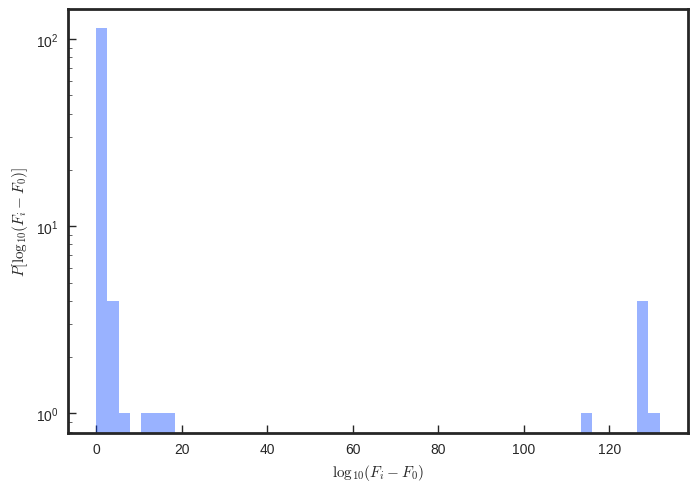

In [66]:
fig, ax = plt.subplots(1,1)
sns.distplot(cviol_obj[np.where(cviol_obj > 0.0)[0]], kde=False, ax=ax)

ax.set_yscale('log')

ax.set_ylabel(r'$P[\log_{10}(F_i - F_0)]$')
ax.set_xlabel(r'$\log_{10}(F_i - F_0)$')

plt.show()

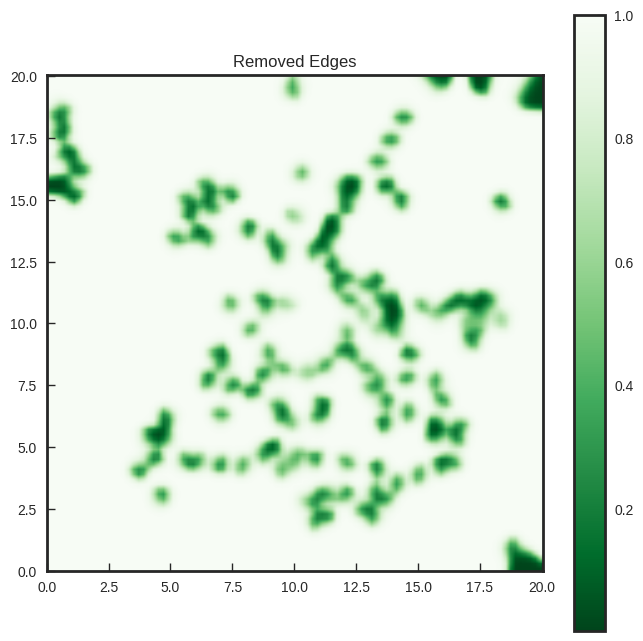

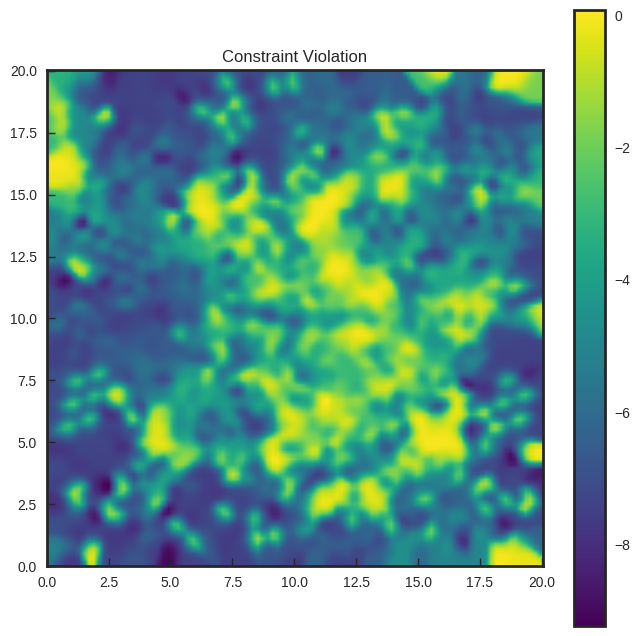

In [21]:
mpl.rcParams['mathtext.fontset'] = 'cm'
sns.set_context('poster', font_scale=1.25)
# sns.set_color_codes(palette='deep')
sns.set(color_codes=True, palette='deep')
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})

nw_label = data['network_label']

removed = np.where(data['K_disc'] == 0.0)[0]

with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net = nw_data['network']   
    
stiff = np.ones(net.NE, float)
for edge in removed:
    stiff[edge] = 0.0
    
    
edgei = np.copy(net.edgei)
edgej = np.copy(net.edgej)
node_pos = np.copy(net.node_pos)
DIM = net.DIM
NE = net.NE
NN = net.NN
L = np.copy(net.L)
eq_length = np.copy(net.eq_length)


sigma = np.mean(eq_length)/10

edge_x = np.zeros(NE, float)
edge_y = np.zeros(NE, float)
for i in range(NE):
    posi = node_pos[DIM*edgei[i]:DIM*edgei[i]+DIM]
    posj = node_pos[DIM*edgej[i]:DIM*edgej[i]+DIM]

    pos = (posi + posj) / 2.0        
    pos -= np.floor(pos / L) * L

    edge_x[i] = pos[0]
    edge_y[i] = pos[1]
    
    
    
    
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1, 1, 1, aspect=1.0)

ax1.set_title("Removed Edges")
    
plot = nplot.scalar_field(ax1, edge_x, edge_y, stiff, np.mean(eq_length)/4, 100, L, cmap=mpl.cm.Greens_r)

cb = fig.colorbar(plot)
    
plt.show()



fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1, 1, 1, aspect=1.0)

ax1.set_title("Constraint Violation")

cviol = np.zeros(NE)
for edge in cviol_edges:
    cviol[edge] = np.log10(cviol_obj[edge])
    
plot = nplot.scalar_field(ax1, edge_x, edge_y, cviol, np.mean(eq_length)/4, 100, L, cmap=mpl.cm.viridis)

cb = fig.colorbar(plot)
    
plt.show()


# fig = plt.figure(figsize=(8,8))
# ax1 = fig.add_subplot(1, 1, 1, aspect=1.0)

# ax1.set_title("Constraint Violation")

# cviol = np.zeros(NE)
# for edge in cviol_edges:
#     cviol[edge] = np.log10(cviol_obj[edge])
    
# plot = nplot.scalar_field(ax1, edge_x, edge_y, cviol, np.mean(eq_length)/4, 100, L, cmap=mpl.cm.viridis)

# cb = fig.colorbar(plot)
    
# plt.show()


In [173]:
stiff = []
edge_x = []
edge_y = []
eq_length = []


for n in range(32):
    
    print n

    DIM = 2

    NN = 256
    Lp = -1.0
    irec = n
    Delta = 10.0

    NDISC = 1.0

    rand.seed(irec)

    nw_label = "network_periodic_jammed/network_N{:05d}_Lp{:.2f}/network_irec{:04d}".format(NN, Lp, irec)

    with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

        nw_data = pickle.load(pkl_file)
        net = nw_data['network'] 


    NF = 1


    edgei = net.edgei
    edgej = net.edgej


    inodesi = [[] for t in range(NF)]
    inodesj = [[] for t in range(NF)]
    istrain_bonds = [[] for t in range(NF)]

    onodesi = [[] for t in range(NF)]
    onodesj = [[] for t in range(NF)]
    ostrain_bonds = [[] for t in range(NF)]

    edge_set = set()



    ##################################################

    L = np.copy(net.L)

    pos = np.array([0.5*L[0], 0.5*L[1]])
    s = network.closestEdge(net, pos)[0]


    inodesi[0].append(edgei[s])
    inodesj[0].append(edgej[s])
    istrain_bonds[0].append(s)

    NTS = 1

    dtheta = 2*np.pi / 8

    for i in range(NTS):
        pos = np.array([0.5, 0.5])
        pos += 0.4 * np.array([np.sin(i * dtheta), np.cos(i * dtheta)])
        pos *= L

        t1 = network.closestEdge(net, pos)[0]
        onodesi[0].append(edgei[t1])
        onodesj[0].append(edgej[t1])
        ostrain_bonds[0].append(t1)


    ######################################################

    isvec = [[] for t in range(NF)]
    for t in range(NF):
        for (i, j) in zip(inodesi[t], inodesj[t]):
            posi = net.node_pos[DIM*i:DIM*i+DIM]
            posj = net.node_pos[DIM*j:DIM*j+DIM]
            bvec = posj - posi
            bvec -= np.round(bvec/net.L)*net.L
            isvec[t].extend(bvec) 

    istrain = [[] for t in range(NF)]
    istrain[0].append(1.0)


    osvec = [[] for t in range(NF)]
    ostrain = [[] for t in range(NF)]
    for t in range(NF):
        for (i, j) in zip(onodesi[t], onodesj[t]):
            posi = net.node_pos[DIM*i:DIM*i+DIM]
            posj = net.node_pos[DIM*j:DIM*j+DIM]
            bvec = posj - posi
            bvec -= np.round(bvec/net.L)*net.L
            osvec[t].extend(bvec) 


            ostrain[t].append(Delta)

    pert = []
    meas = []
    for t in range(NF):
        pert.append(talgs.Perturb())
    #     pert[t].setInputStress(len(istrain_bonds[t]), istrain_bonds[t], istrain[t])
        pert[t].setInputStrain(len(inodesi[t]), inodesi[t], inodesj[t], istrain_bonds[t], istrain[t], isvec[t])

        meas.append(talgs.Measure())
    #     meas[t].setOutputStress(len(ostrain_bonds[t]), ostrain_bonds[t])
        meas[t].setOutputStrain(len(onodesi[t]), onodesi[t], onodesj[t], ostrain_bonds[t], osvec[t])

    obj_func = mns.CyIneqRatioChangeObjFunc(len(np.concatenate(ostrain)), net.NE, 
                                            np.zeros(len(np.concatenate(ostrain)), float), np.concatenate(ostrain),
                                           relative=False, change=False)    


    K_max = np.ones(net.NE, float) / net.eq_length

    K_disc = np.ones(net.NE, float)


    tuner = talgs.TuneDiscLin(net, pert, meas, obj_func, K_max, K_disc, NDISC=NDISC)

    data = tuner.tune(verbose=False)
    
    if data['success_flag'] != 0.0:
        continue
    else:
        print "success"
    
    edgei = np.copy(net.edgei)
    edgej = np.copy(net.edgej)
    node_pos = np.copy(net.node_pos)
    NE = net.NE
    NN = net.NN
    
    
    for i in range(NE):
        posi = node_pos[DIM*edgei[i]:DIM*edgei[i]+DIM]
        posj = node_pos[DIM*edgej[i]:DIM*edgej[i]+DIM]

        pos = (posi + posj) / 2.0   
        pos /= L
        pos -= np.floor(pos)

        edge_x.append(pos[0])
        edge_y.append(pos[1])

    
    removed = set(np.where(data['K_disc'] == 0.0)[0])
    for i in range(NE):
        if i in removed:
            stiff.append(0.0)
        else:
            stiff.append(1.0)

    eq_length.extend(net.eq_length / np.mean(L))
    

0
success
1
success
2
success
3
success
4
success
5
success
6
success
7
success
8
success
9
success
10
success
11
success
12
success
13
success
14
success
15
Steps Backwards 1 / 1
16
Steps Backwards 1 / 1
17
success
18
success
19
success
20
success
21
success
22
Steps Backwards 1 / 1
23
success
24
success
25
success
26
success
27
success
28
success
29
success
30
success
31
success


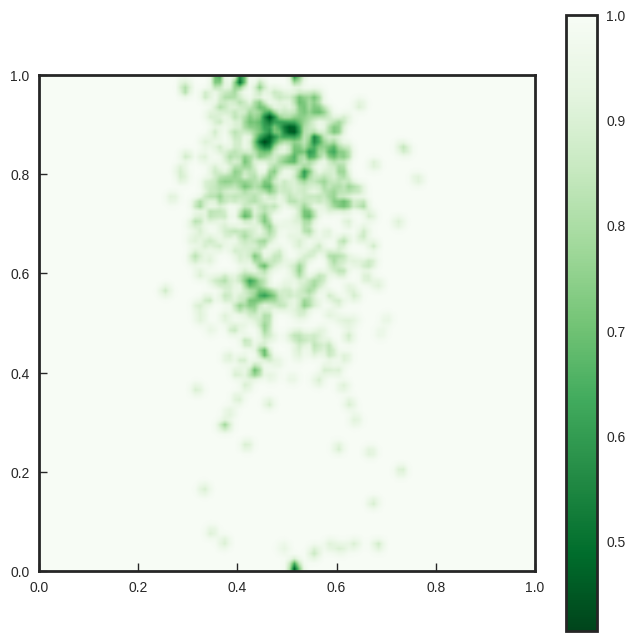

In [175]:
mpl.rcParams['mathtext.fontset'] = 'cm'
sns.set_context('poster', font_scale=1.25)
# sns.set_color_codes(palette='deep')
sns.set(color_codes=True, palette='deep')
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1, 1, 1, aspect=1.0)



plot = scalar_field(ax1, np.array(edge_x), np.array(edge_y), np.array(stiff), 
                    np.mean(eq_length) / 8, 100, np.array([1.0, 1.0]), cmap=mpl.cm.Greens_r)

cb = fig.colorbar(plot)
    
plt.show()